# Practica 4
## Objetivos

1. A partir del espectrograma Mel calcularemos los coeficientes MFCC (Mel Frequency Cepstral Coefficients)

2. A partir del espectrograma lineal extraeremos otras características (features) espectrales.

3. Construiremos el vector de features que va a “describir” al fichero de audio: Cada fichero *.wav se “representará” por un único vector de 85 componentes.

In [8]:
import os
import numpy as np
import scipy.io.wavfile as wav
import scipy.fft as fft
import scipy
import matplotlib.pyplot as plt
import librosa as lr

from dataclasses import dataclass

In [9]:
@dataclass
class Signal:
    """
    Data class to represent a signal
    """

    y: np.ndarray
    fs: int
    file: str

    def from_file(filename):
        """
        Create a Signal object from a file

        Parameters
        ----------
        filename : str
            The name of the file to read

        Returns
        -------
        Signal
            The Signal object created from the file
        """

        # read the audio file
        fs, y = wav.read(filename)

        # normalize the signal if it is not already normalized
        # to normalize the signal we divide by the maximum possible value of the data type
        if np.any(abs(y) > 1):
            if np.issubdtype(y.dtype, np.integer):
                y = y / np.iinfo(y.dtype).max
            elif np.issubdtype(y.dtype, np.floating):
                y = y / np.finfo(y.dtype).max
            else:
                raise ValueError("Could not normalize signal")

        return Signal(y, fs, os.path.basename(filename))

    def plot(self, title):
        """
        Plot the signal

        Parameters
        ----------
        title : str
            The title of the plot

        Returns
        -------
        None
        """
        t = np.arange(len(self.y)) / self.fs

        plt.plot(t, self.y)
        plt.xlabel("Time (s)")
        plt.title(title)

        plt.show()

## Ejercicio 4.1
Recortamos la señal usando un VAD y la representamos.

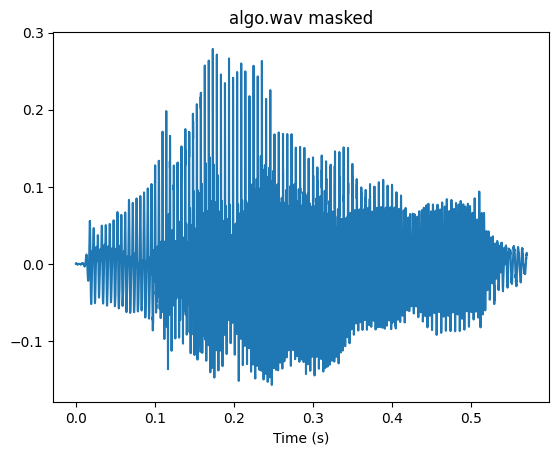

In [10]:
AUDIO_DIR = "audio/"

signal = Signal.from_file(os.path.join(AUDIO_DIR, "algo.wav"))

frame_duration = 0.032  # frame duration in seconds
overlap_duration = frame_duration / 2  # overlap duration in seconds

frame_length = round(frame_duration * signal.fs)  # frame length in samples
overlap_samples = round(overlap_duration * signal.fs)  # overlap length in samples
n_fft = 2 ** (frame_length - 1).bit_length()  # FFT length in samples

# # remove the silent parts of the signal
# masked_y, mask_idx = lr.effects.trim(signal.y, top_db=15)
# mask = np.zeros(len(signal.y))
# mask[mask_idx[0] : mask_idx[1]] = np.max(signal.y)
#
# # plot the mask
# t = np.arange(len(signal.y)) / signal.fs
#
# plt.plot(t, signal.y)
# plt.plot(t, mask)
# plt.xlabel("Time (s)")
# plt.title(f"{signal.file} mask")
# plt.legend(["Signal", "Mask"])
# plt.show()
#
# # update the original signal with the masked version with the silent parts removed
# signal.y = masked_y

# plot the signal
signal.plot(f"{signal.file} masked")

## Ejercicio 4.2
Obtenemos el espectrograma de Mel y calculamos los coeficientes MFCC usando la transformada discreta del coseno y lo comparamos con el resultado de la propia función ofrecida por `librosa` para hacer el cálculo directo.

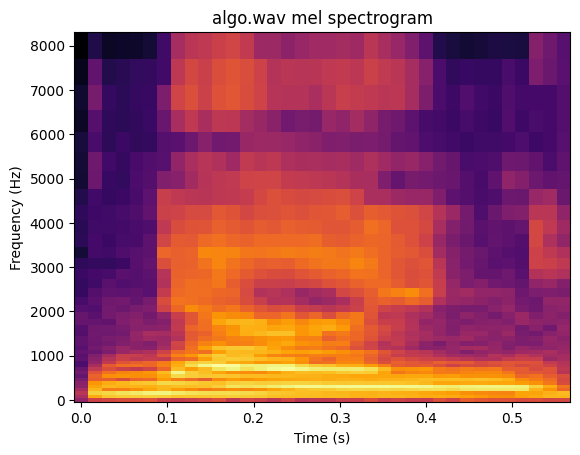

In [11]:
n_mels = 40  # number of mel bands
n_mfcc = 13  # number of MFCC coefficients

fig, ax = plt.subplots()
ax.set_title(f"{signal.file} mel spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")

# compute the mel spectrogram
S = lr.feature.melspectrogram(
    y=signal.y,
    sr=signal.fs,
    n_fft=n_fft,
    hop_length=overlap_samples,
    n_mels=n_mels,
)

t = lr.times_like(S, sr=signal.fs, hop_length=overlap_samples)
f = lr.mel_frequencies(n_mels, fmin=0, fmax=signal.fs // 2)
T, F = np.meshgrid(t, f)

# plot the mel spectrogram
ax.pcolormesh(T, F, 10 * np.log10(S), cmap="inferno")
plt.show()

(12,)


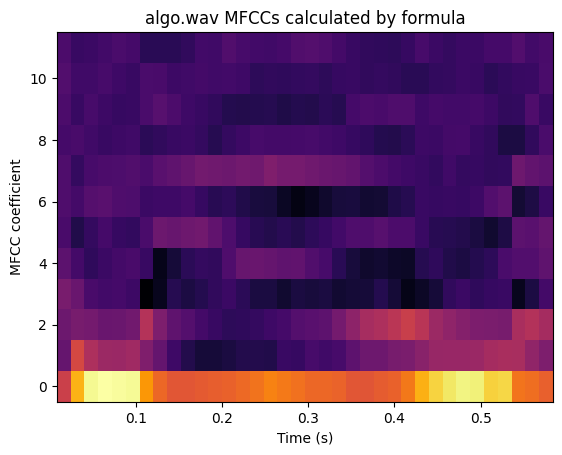

(12,)


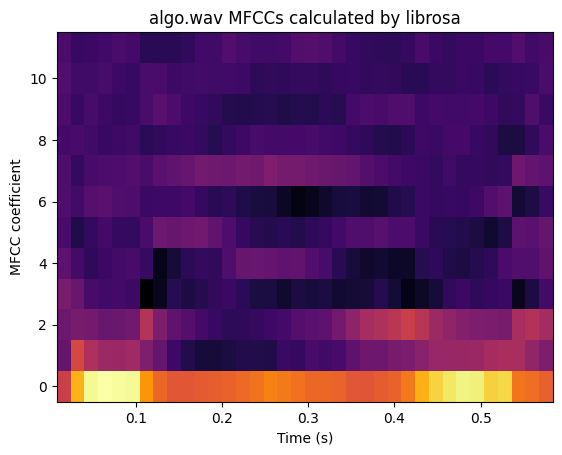

True


In [12]:
# calculate the MFCCs using the formula
mfcc_formula = fft.dct(lr.power_to_db(S), axis=0, norm="ortho")[:n_mfcc]

# calculate the mffcc coefficients directly using librosa
mfcc_librosa = lr.feature.mfcc(
    y=signal.y,
    sr=signal.fs,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    hop_length=overlap_samples,
    n_mels=n_mels,
)

# plot the MFCCs
for mfcc, mfcc_name in zip(
    [mfcc_formula, mfcc_librosa], ["calculated by formula", "calculated by librosa"]
):
    mfcc = mfcc[1:n_mfcc]  # we skip the first coefficient

    fig, ax = plt.subplots()
    ax.set_title(f"{signal.file} MFCCs {mfcc_name}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MFCC coefficient")

    t = lr.times_like(mfcc, sr=signal.fs, hop_length=overlap_samples, n_fft=n_fft)
    y = np.arange(n_mfcc - 1)  # we skip the first coefficient
    ax.pcolormesh(t, y, mfcc, cmap="inferno")

    plt.show()

mfcc = mfcc_librosa

# check if the MFCCs calculated by the formula and by librosa are equal
print(np.array_equal(mfcc_formula, mfcc))

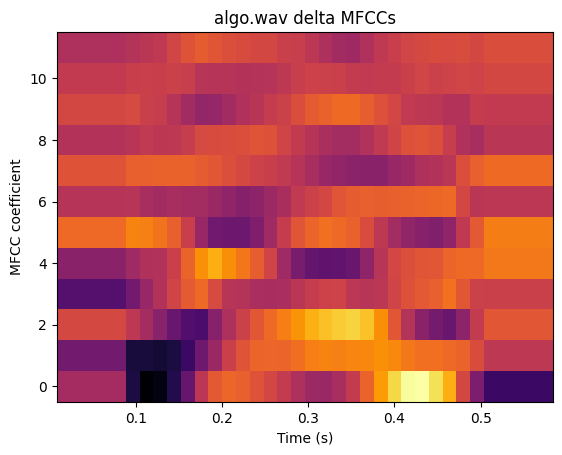

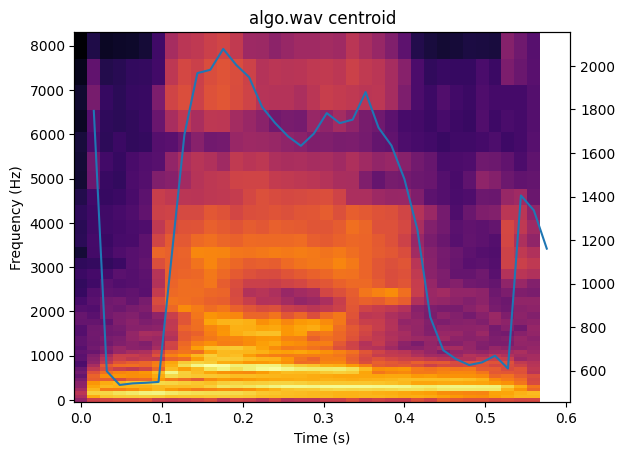

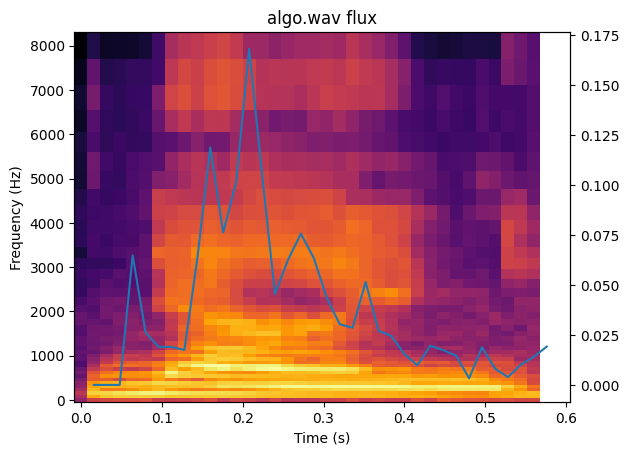

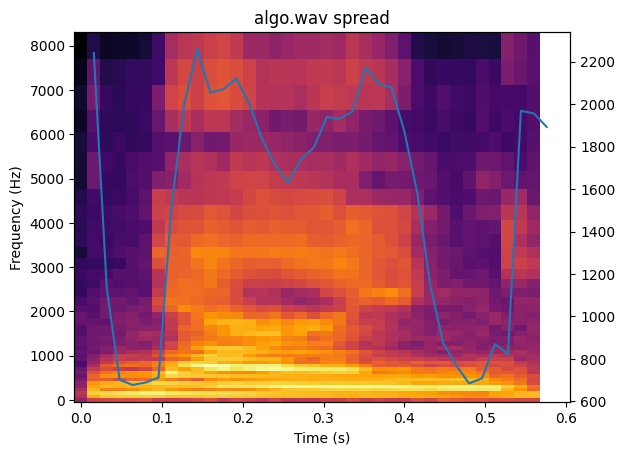

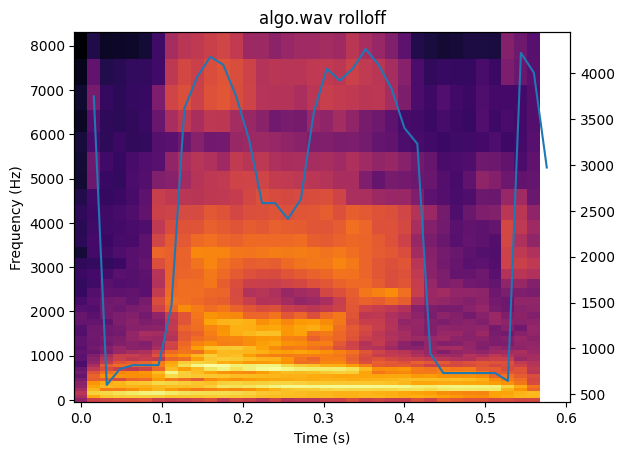

In [13]:
features = []
spec = np.abs(lr.stft(signal.y, n_fft=n_fft, hop_length=overlap_samples))

centroid = lr.feature.spectral_centroid(S=spec)[0]
features.append(centroid)

flux = lr.onset.onset_strength(S=spec)
features.append(flux)

spread = lr.feature.spectral_bandwidth(S=spec)[0]
features.append(spread)

rolloff = lr.feature.spectral_rolloff(S=spec)[0]
features.append(rolloff)

delta_mfcc = lr.feature.delta(mfcc)[1:n_mfcc]

# plot the delta MFCCs
fig, ax = plt.subplots()
ax.set_title(f"{signal.file} delta MFCCs")
ax.set_xlabel("Time (s)")
ax.set_ylabel("MFCC coefficient")

t = lr.times_like(delta_mfcc, sr=signal.fs, hop_length=overlap_samples, n_fft=n_fft)
y = np.arange(n_mfcc - 1)  # we skip the first coefficient
ax.pcolormesh(t, y, delta_mfcc, cmap="inferno")

plt.show()

# plot the features and the spectrogram in the same plot
for feature, feature_name in zip(
    features, ["centroid", "flux", "spread", "rolloff", "kurtosis"]
):
    fig, ax = plt.subplots()
    ax.set_title(f"{signal.file} {feature_name}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(feature_name)

    t = lr.times_like(feature, sr=signal.fs, hop_length=overlap_samples, n_fft=n_fft)
    ax.set_ylabel("Frequency (Hz)")
    ax.pcolormesh(T, F, 10 * np.log10(S), cmap="inferno")

    ax2 = ax.twinx()
    ax2.plot(t, feature)

    plt.show()

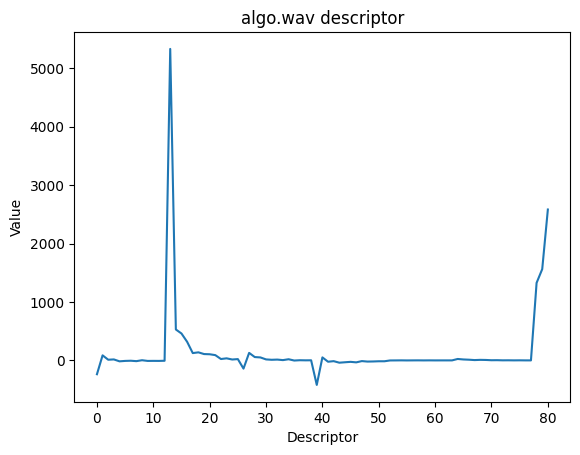

In [14]:
descriptor = np.array([])
descriptor = np.append(descriptor, np.mean(mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.var(mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.max(mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.min(mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.mean(delta_mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.var(delta_mfcc, axis=1).flatten())
descriptor = np.append(descriptor, np.mean(flux))
descriptor = np.append(descriptor, np.var(flux))
descriptor = np.append(descriptor, np.mean(centroid))
descriptor = np.append(descriptor, np.mean(spread))
descriptor = np.append(descriptor, np.mean(rolloff))

# plot the descriptor
fig, ax = plt.subplots()
ax.set_title(f"{signal.file} descriptor")
ax.set_xlabel("Descriptor")
ax.set_ylabel("Value")

x = np.arange(len(descriptor))
plt.plot(x, descriptor)

plt.show()